In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy import stats

tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


C:\Users\Forry\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


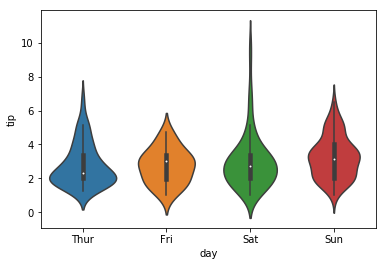

In [2]:
#显示数据集中的day和tip列
sns.violinplot(x='day', y='tip', data=tips)

In [2]:
#创建分类编码x，分别以0,1,2,3表示星期四，星期五，星期六，星期天
y1 = tips['tip'].values
x = pd.Categorical(tips['day']).codes


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sds, means]
100%|█████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:13<00:00, 405.76it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C48B9FEC50>,
      dtype=object)

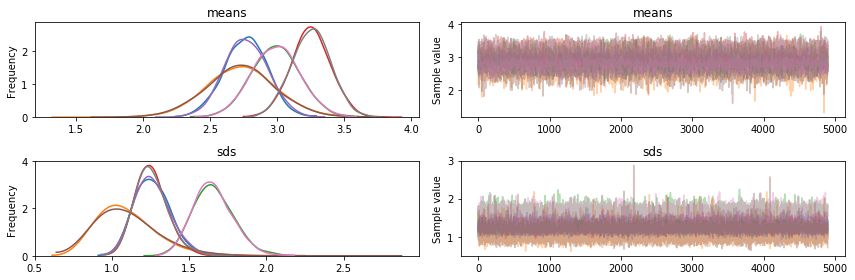

In [31]:
#创建模型
with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(x)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(x)))
    
    y = pm.Normal('y', mu=means[x], sd=sds[x], observed=y1)
    
    trace_cg = pm.sample(5000, cores=1)

chain_cg = trace_cg[100::]
pm.traceplot(chain_cg)

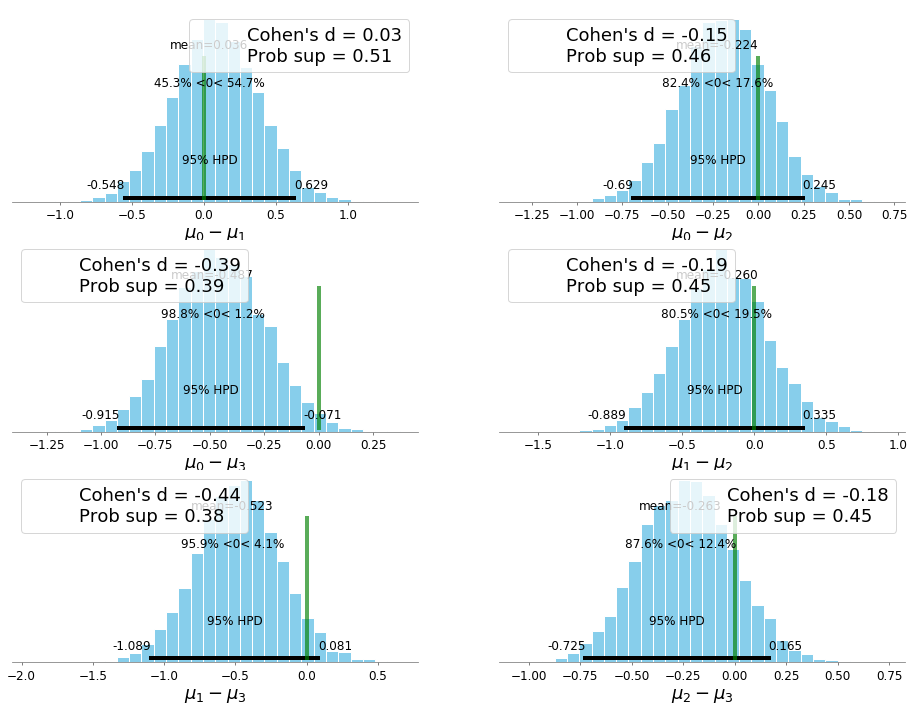

In [46]:
dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(16, 12))#tuple
#ax = np.array(ax1)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:,i]-chain_cg['means'][:,j]
    #计算Cohen's d
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:,i]**2 + chain_cg['sds'][:,j]**2) / 2)).mean()
    #计算概率优势
    ps = dist.cdf(d_cohen / (2**0.5))
    
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], color='skyblue')
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j), fontsize=18)
    ax[k, l].legend(loc=0, fontsize=18)